# <center> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
%pylab inline
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

Populating the interactive namespace from numpy and matplotlib


## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [2]:
with open('capstone_websites_data/X_sparse_10users.pkl', 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open('capstone_websites_data/y_10users.pkl', 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 13 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [3]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_sparse_10users, y_10users, 
    test_size=0.3, 
    random_state=7, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=7 – для воспроизводимости.**

In [5]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [6]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

In [7]:
def write_answer_to_file(answer, file_address):
    with open(file_address, 'w') as out_f:
        out_f.write(str(answer))

**1. Обучите KNeighborsClassifier со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только n_jobs=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект StratifiedKFold skf) по выборке (X_train, y_train) и отдельно на выборке (X_valid, y_valid).**

In [8]:
from sklearn.neighbors import KNeighborsClassifier

In [9]:
knn = KNeighborsClassifier(100, n_jobs=-1)

In [10]:
%%time
knn_cv_scores = cross_val_score(knn, X_train, y_train, cv=skf)

CPU times: user 1.35 s, sys: 610 ms, total: 1.96 s
Wall time: 2.94 s


In [11]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=100, p=2,
           weights='uniform')

In [12]:
%%time
knn_valid_acc = accuracy_score(knn.predict(X_valid), y_valid)

CPU times: user 910 ms, sys: 590 ms, total: 1.5 s
Wall time: 2.25 s


**Запишите в файл *answer4_1.txt* доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [13]:
write_answer_to_file("{} {}".format(round(float(np.mean(knn_cv_scores)), 3), 
                                    round(knn_valid_acc, 3)),
                     'answer4_1.txt')

**2. Обучите случайный лес (RandomForestClassifier) из 100 деревьев (для воспроизводимости random_state=7). Посмотрите на OOB-оценку (для этого надо сразу установить oob_score=True) и на долю правильных ответов на выборке (X_valid, y_valid). Для распараллеливания задайте n_jobs=-1.**

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
forest = RandomForestClassifier(100, random_state=7, oob_score=True, n_jobs=-1).fit(X_train, y_train)

In [17]:
rf_valid_acc = accuracy_score(forest.predict(X_valid), y_valid)

**Запишите в файл *answer4_2.txt* доли правильных ответов для RandomForestClassifier при Out-of-Bag оценке на и отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [18]:
write_answer_to_file("{} {}".format(round(forest.oob_score_, 3), round(rf_valid_acc, 3)),
                     'answer4_2.txt')

**3. Обучите логистическую регрессию (LogisticRegression) с параметром C по умолчанию и random_state=7 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект skf, созданный ранее) и на выборке (X_valid, y_valid). Для распараллеливания задайте n_jobs=-1.**

In [19]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [20]:
logit = LogisticRegression(random_state=7, n_jobs=-1)

In [22]:
%%time
logit_cv_scores = cross_val_score(logit, X_train, y_train, cv=skf)

CPU times: user 1.53 s, sys: 6.67 ms, total: 1.54 s
Wall time: 1.55 s


In [23]:
logit.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=7, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [24]:
accuracy_score(logit.predict(X_valid), y_valid)

0.76416212372600145

**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации C (быстрее, чем с GridSearchCV).**

**С помощью LogisticRegressionCV подберите параметр C для LogisticRegression сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте linspace из NumPy. Укажите у LogisticRegressionCV параметры multi_class='multinomial' и random_state=7. Для кросс-валидации используйте объект skf, созданный ранее. Для распараллеливания задайте n_jobs=-1.**

**Нарисуйте кривые валидации по параметру С.**

In [26]:
%%time
logit_c_values1 = np.linspace(1e-4, 1e4, 10)

logit_grid_searcher1 = LogisticRegressionCV(
    Cs = logit_c_values1,
    multi_class = 'multinomial',
    random_state = 7, 
    n_jobs = -1, 
    cv = skf)

logit_grid_searcher1.fit(X_train, y_train)

CPU times: user 2.06 s, sys: 310 ms, total: 2.37 s
Wall time: 26.4 s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров С.

In [63]:
logit_mean_cv_scores1 = np.array(
    [matr.mean(axis=0) for key, matr in logit_grid_searcher1.scores_.items()]).mean(axis=0)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение С.

In [68]:
np.max(logit_mean_cv_scores1), logit_c_values1[np.argmax(logit_mean_cv_scores1)]

(0.74609152739484919, 1111.1112000000001)

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

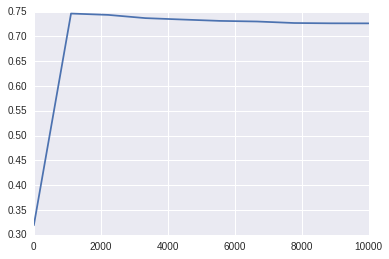

In [64]:
plot(logit_c_values1, logit_mean_cv_scores1);

**Теперь то же самое, только значения параметра C перебирайте в диапазоне np.linspace(1e-3, 1, 30). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [72]:
%%time
logit_c_values2 = np.linspace(1e-3, 1, 30)

logit_grid_searcher2 = LogisticRegressionCV(
    Cs = logit_c_values2,
    multi_class = 'multinomial',
    random_state = 7, 
    n_jobs = -1, 
    cv = skf)

logit_grid_searcher2.fit(X_train, y_train)

CPU times: user 2 s, sys: 363 ms, total: 2.37 s
Wall time: 1min 10s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров С.

In [73]:
logit_mean_cv_scores2 = np.array(
    [matr.mean(axis=0) for key, matr in logit_grid_searcher2.scores_.items()]).mean(axis=0)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение С.

In [74]:
np.max(logit_mean_cv_scores2), logit_c_values2[np.argmax(logit_mean_cv_scores2)]

(0.7493420452779368, 0.75886206896551722)

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

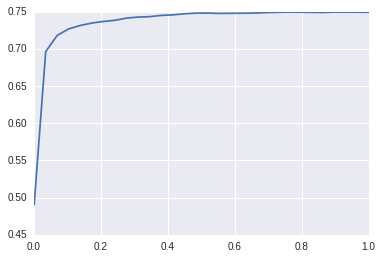

In [75]:
plot(logit_c_values2, logit_mean_cv_scores2);

Выведите долю правильных ответов на выборке (X_valid, y_valid) для логистической регрессии с лучшим найденным значением C.

In [78]:
logit_cv_acc = accuracy_score(y_valid, logit_grid_searcher2.predict(X_valid))

**Запишите в файл *answer4_3.txt* доли правильных ответов для logit_grid_searcher2 на кросс-валидации для лучшего значения параметра С и на отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [79]:
write_answer_to_file("{} {}".format(round(float(np.max(logit_mean_cv_scores2)), 3), 
                                    round(logit_cv_acc, 3)),
                     'answer4_3.txt')

**4. Обучите линейный SVM (LinearSVC) с параметром C=1 и random_state=7 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект skf, созданный ранее) и на выборке (X_valid, y_valid).**

In [80]:
from sklearn.svm import LinearSVC

In [81]:
svm = LinearSVC(C=1.0, random_state=7)

In [82]:
svm_cv_scores = cross_val_score(svm, X_train, y_train, cv=skf)

In [84]:
accuracy_score(y_valid, svm.fit(X_train, y_train).predict(X_valid))

0.75373311211187488

**С помощью GridSearchCV подберите параметр C для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте linspace из NumPy. Нарисуйте кривые валидации.**

In [86]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(
    LinearSVC(random_state=7), 
    param_grid=svm_params1, 
    cv=skf, 
    n_jobs=-1)
svm_grid_searcher1.fit(X_train, y_train)

CPU times: user 6.96 s, sys: 56.7 ms, total: 7.02 s
Wall time: 49.2 s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение С.

In [87]:
svm_grid_searcher1.best_score_, svm_grid_searcher1.best_params_

(0.67303393619183094, {'C': 8888.8888999999999})

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

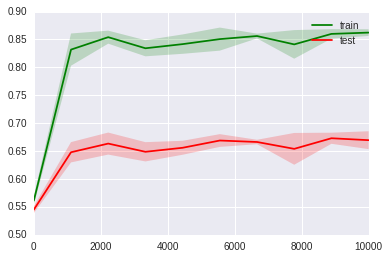

In [88]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений C). Здесь намного осмысленней подбирать C в районе 1, к тому же, так модель быстрее обучается, чем при больших C. **

**С помощью GridSearchCV подберите параметр C для SVM в диапазоне (1e-3, 1), 30 значений, используйте linspace из NumPy. Нарисуйте кривые валидации.**

In [90]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(
    LinearSVC(random_state=7), 
    param_grid=svm_params2, 
    cv=skf, 
    n_jobs=-1)
svm_grid_searcher2.fit(X_train, y_train)

CPU times: user 1.22 s, sys: 96.7 ms, total: 1.31 s
Wall time: 1min 16s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение С.

In [91]:
svm_grid_searcher2.best_score_, svm_grid_searcher2.best_params_

(0.75147327778906725, {'C': 0.10434482758620689})

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

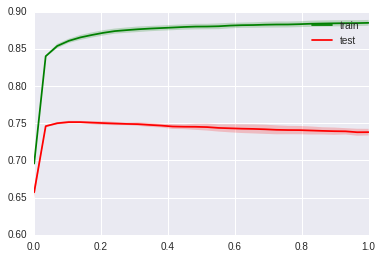

In [92]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке (X_valid, y_valid) для LinearSVC с лучшим найденным значением C.

In [93]:
svm_cv_acc = accuracy_score(y_valid, svm_grid_searcher2.best_estimator_.predict(X_valid))

**Запишите в файл *answer4_4.txt* доли правильных ответов для svm_grid_searcher2 на кросс-валидации для лучшего значения параметра С и на отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [94]:
write_answer_to_file("{} {}".format(round(svm_grid_searcher2.best_score_, 3), 
                                    round(svm_cv_acc, 3)),
                     'answer4_4.txt')

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем LinearSVC, показавший лучшее качество на кросс-валидации в 1 части и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации C.**

**Определите функцию model_assessment, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с train_test_split должно быть стратифицированным. Не теряйте нигде random_state.**

In [103]:
def model_assessment(
    estimator, path_to_X_pickle, path_to_y_pickle, cv, 
    random_state=7, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    
    with open(path_to_X_pickle, 'rb') as X_sparse_users_pkl:
        X_sparse_users = pickle.load(X_sparse_users_pkl)
    with open(path_to_y_pickle, 'rb') as y_users_pkl:
        y_users = pickle.load(y_users_pkl)
    
    
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_sparse_users, y_users, 
        test_size=test_size, 
        random_state=random_state, stratify=y_users)
    
    res1 = np.mean(cross_val_score(estimator, X_train, y_train, cv=cv))
    res2 = accuracy_score(y_valid, estimator.predict(X_valid))
    
    return res1, res2

**Убедитесь, что функция работает.**

In [104]:
model_assessment(
    svm_grid_searcher2.best_estimator_, 
    'capstone_websites_data/X_sparse_10users.pkl',
    'capstone_websites_data/y_10users.pkl', skf, random_state=7, test_size=0.3)

(0.75147489387697275, 0.76534723868215215)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, svm\_grid\_searcher2.best\_estimator\_) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем скромном маке этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

In [105]:
%%time
estimator = svm_grid_searcher2.best_estimator_
results = []

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length and (window_size, session_length):
        try:
            path_to_X_pkl = 'capstone_websites_data/X_sparse_10users_s{}_w{}.pkl'.format(session_length, window_size)
            path_to_y_pkl = 'capstone_websites_data/y_10users_s{}_w{}.pkl'.format(session_length, window_size)
            res = model_assessment(
                estimator, 
                path_to_X_pkl,
                path_to_y_pkl, skf)
            results.append((session_length, window_size, res))
        except Exception as ex:
            # import pdb; pdb.set_trace()
            pass

CPU times: user 21.7 s, sys: 10 ms, total: 21.7 s
Wall time: 21.8 s


In [106]:
from pprint import pprint
pprint(results)

[(15, 10, (0.806444362098928, 0.81275183692818198)),
 (15, 7, (0.83605964684108625, 0.85382445661191309)),
 (10, 7, (0.7823613773063407, 0.81997677119628343)),
 (7, 7, (0.73179342391668101, 0.78463580554172885)),
 (15, 5, (0.85067533382539828, 0.85633001422475108)),
 (10, 5, (0.80037469809972384, 0.82799905168326215)),
 (7, 5, (0.7549005714615028, 0.79208155523945001)),
 (5, 5, (0.70460033904135422, 0.75))]


**Запишите в файл *answer4_5.txt* доли правильных ответов для LinearSVC с настроенным параметром C и выборки *X_sparse_10users_s15_w5*. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [109]:
res1, res2 = model_assessment(
    svm_grid_searcher2.best_estimator_, 
    'capstone_websites_data/X_sparse_10users_s15_w5.pkl',
    'capstone_websites_data/y_10users_s15_w5.pkl', skf, random_state=7, test_size=0.3)

In [110]:
write_answer_to_file("{} {}".format(round(res1, 3), 
                                    round(res2, 3)),
                     'answer4_5.txt')

**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [ ]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:
    if window_size <= session_length and (window_size, session_length):
        path_to_X_pkl = ''' ВАШ КОД ЗДЕСЬ '''
        path_to_y_pkl = ''' ВАШ КОД ЗДЕСЬ '''
        print           ''' ВАШ КОД ЗДЕСЬ '''

**Запишите в файл *answer4_6.txt* доли правильных ответов для LinearSVC с настроенным параметром C и выборки *X_sparse_150users*. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [153]:
with open('capstone_websites_data/X_sparse_150users.pkl', 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open('capstone_websites_data/y_150users.pkl', 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [154]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(
    X_sparse_150users, 
    y_150users, test_size=0.3, 
    random_state=7, stratify=y_150users)

In [ ]:
svm_params3 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher3 = GridSearchCV(
    LinearSVC(random_state=7), 
    param_grid=svm_params3, 
    cv=skf, 
    n_jobs=-1)
svm_grid_searcher3.fit(X_train_150, y_train_150)

In [157]:
res1, res2 = model_assessment(
    LinearSVC(C=svm_grid_searcher2.best_params_['C'], random_state=7).fit(X_train_150, y_train_150), 
    'capstone_websites_data/X_sparse_150users.pkl',
    'capstone_websites_data/y_150users.pkl', skf, random_state=7, test_size=0.3)

In [158]:
write_answer_to_file("{} {}".format(round(res1, 3), 
                                    round(res2, 3)),
                     'answer4_6.txt')

## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 10 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [118]:
with open('capstone_websites_data/X_sparse_150users.pkl', 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open('capstone_websites_data/y_150users.pkl', 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [119]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=7, stratify=y_150users)

**Обучите LogisticRegressionCV для одного значения параметра C (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент multi_class='ovr'. Как всегда, где возможно, указывайте n_jobs=-1 и random_state=7.**

In [120]:
%%time
logit_cv_150users = LogisticRegressionCV(
    Cs=[svm_grid_searcher1.best_params_['C']],
    multi_class='ovr',
    n_jobs=-1, 
    random_state=7)
logit_cv_150users.fit(X_train_150, y_train_150)

CPU times: user 4min 41s, sys: 41.4 s, total: 5min 23s
Wall time: 10min 32s


**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [124]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    print('User {}, CV score: {}'.format(user_id, logit_cv_150users.scores_[user_id].mean()))

User 0, CV score: 0.9954333402618833
User 1, CV score: 0.9966633378876696
User 2, CV score: 0.994776106966984
User 3, CV score: 0.9910961350730085
User 4, CV score: 0.989615939300298
User 5, CV score: 0.9936084927449632
User 6, CV score: 0.9931396039528249
User 7, CV score: 0.9852360361087019
User 8, CV score: 0.9979564671519557
User 9, CV score: 0.9948704182072593
User 10, CV score: 0.9935775577147234
User 11, CV score: 0.9935462318639888
User 12, CV score: 0.996340323276743
User 13, CV score: 0.9943182387007288
User 14, CV score: 0.9961109094436075
User 15, CV score: 0.9957043943751485
User 16, CV score: 0.9902721551146655
User 17, CV score: 0.9940362953163641
User 18, CV score: 0.9941091994747623
User 19, CV score: 0.9911065308350415
User 20, CV score: 0.9809098233535458
User 21, CV score: 0.9966220782739016
User 22, CV score: 0.9939628681345939
User 23, CV score: 0.9910023715303669
User 24, CV score: 0.9964239854514575
User 25, CV score: 0.9936300393395693
User 26, CV score: 0.9944

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью LogisticRegressionCV) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [159]:
class_distr = np.bincount(y_train_150.astype('int'))
acc_diff_vs_constant = []
for user_id in np.unique(y_train_150):
    acc_diff_vs_constant.append(logit_cv_150users.scores_[user_id].mean() - 
                                float((float(class_distr.sum()) - float(class_distr[user_id]))/float(class_distr.sum())))

In [161]:
num_better_than_default = float((np.array(acc_diff_vs_constant) > 0).sum())

**Запишите в файл *answer4_7.txt* долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой. **

In [162]:
write_answer_to_file("{}".format(round(num_better_than_default/150.0, 3)),
                     'answer4_7.txt')

**Дальше будем строить кривые обучения для конткретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [ ]:
y_binary_128 = ''' ВАШ КОД ЗДЕСЬ '''

In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [ ]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve ''' ВАШ КОД ЗДЕСЬ '''

In [ ]:
plot_learning_curve(val_train, val_test, n_train, xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

## Пути улучшения
В этом проекте свобода творчества на каждом шаге, а 7 неделя посвящена общему описанию проекта (.ipynb или pdf) и взимному оцениванию. Что еще можно добавить по 4 части проекта:
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/identify-me-if-you-can-yandex-mipt) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей

На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревнование](https://inclass.kaggle.com/c/identify-me-if-you-can-yandex-mipt) Kaggle Inclass.